# So sánh dự báo LTSF với VIC_hidden-test

Notebook này tải toàn bộ file dự báo trong thư mục `submissions`, đối chiếu với dữ liệu thực tế `VIC_hidden-test.csv`, tính toán các chỉ số RMSE/MAE/MSE/R² và trực quan hóa top mô hình.

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8')

In [35]:
hidden_df = pd.read_csv('./data/VIC_hidden-test.csv')
hidden_df['time'] = pd.to_datetime(hidden_df['time'])
hidden_df = hidden_df.sort_values('time').reset_index(drop=True)
hidden_close = hidden_df['close'].astype(float).values
print(f"VIC_hidden-test length: {len(hidden_df)} rows from {hidden_df['time'].min().date()} to {hidden_df['time'].max().date()}")
display(hidden_df.head())

VIC_hidden-test length: 100 rows from 2025-03-11 to 2025-08-01


,time,open,high,low,close,volume,symbol
0,2025-03-11,46.90,47.30,46.50,47.3,5701394,VIC
1,2025-03-12,47.35,48.25,47.35,48.1,7010894,VIC
2,2025-03-13,48.30,51.40,47.50,51.4,16433320,VIC
3,2025-03-14,51.80,52.80,51.40,52.2,8435598,VIC
4,2025-03-17,52.50,52.70,50.80,52.1,6510552,VIC


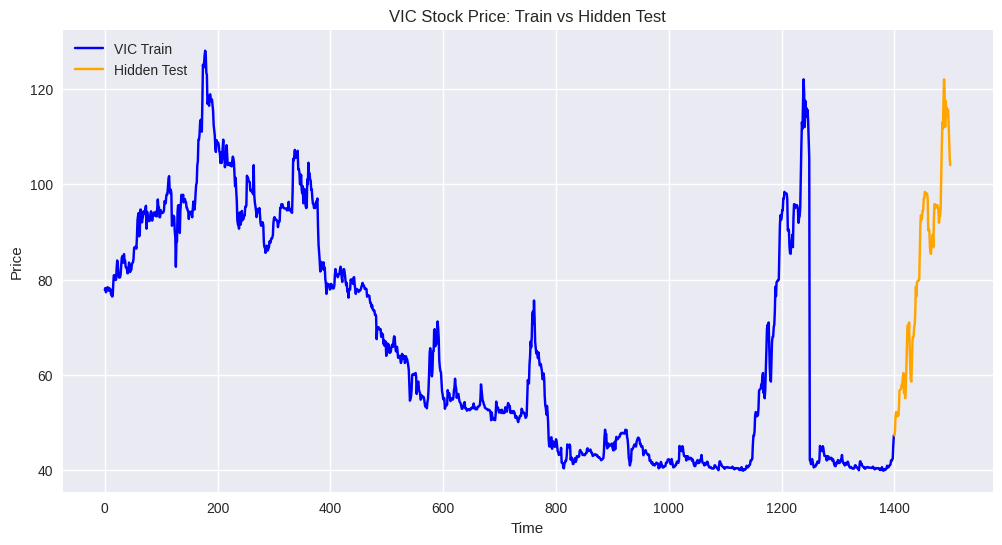

In [36]:
VIC_train = pd.read_csv('./data/VIC_train.csv')

# Plotting
plt.figure(figsize=(12, 6))

# Plot the training data
plt.plot(VIC_train.index, VIC_train['close'], label='VIC Train', color='blue')

# Plot the hidden data, shifting the index to continue from where train left off
# Assuming hidden_df is already defined in the environment
start_index = VIC_train.index[-1] + 1
new_index = range(start_index, start_index + len(hidden_df))
plt.plot(new_index, hidden_df['close'], label='Hidden Test', color='orange')

plt.title('VIC Stock Price: Train vs Hidden Test')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [37]:
submissions_dir = './submissions/VIC/'
forecast_files = sorted([f for f in os.listdir(submissions_dir) if f.startswith('Sub_') and f.endswith('.csv')])
if not forecast_files:
    raise FileNotFoundError('Không tìm thấy file dự báo trong thư mục submissions.')

records = []
max_len = len(hidden_close)
for filename in forecast_files:
    file_path = os.path.join(submissions_dir, filename)
    forecast_df = pd.read_csv(file_path)
    preds = forecast_df['close'].astype(float).values
    aligned_len = min(len(preds), max_len)
    preds_clip = preds[:aligned_len]
    actual_clip = hidden_close[:aligned_len]
    mse = mean_squared_error(actual_clip, preds_clip)
    
    # Fix indentation: This block should run regardless of the try/except outcome
    slug = filename.replace('.csv', '')
        
    # Khởi tạo giá trị mặc định để tránh lỗi NameError
    val_mse = default_val_mse if 'default_val_mse' in locals() else 0 # Ensure default exists
    
    if filename.startswith('Sub_'):
        parts = slug.split('_')
        # Format: Sub_{Model}_{HMM}_{Win}_{Seq}_{MSE}
        # Xử lý linh hoạt cho cả trường hợp thiếu HMM/Win và sửa lỗi thứ tự parse testMSE
        if len(parts) >= 4:
            try:
                mse_tag = parts[-1]   # MSExxx
                # Ưu tiên check testMSE/ValMSE trước MSE để tránh lỗi replace sót ký tự (vd: testMSE -> test)
                if 'testMSE' in mse_tag:
                    val_mse = int(mse_tag.replace('testMSE', ''))
                elif 'ValMSE' in mse_tag:
                    val_mse = int(mse_tag.replace('ValMSE', ''))
                elif 'MSE' in mse_tag:
                    val_mse = int(mse_tag.replace('MSE', ''))
                
                seq_tag = parts[-2]
                
                if len(parts) >= 6:
                    win_tag = parts[-3]
                    hmm_tag = parts[-4]
                    model_name = "_".join(parts[1:-4])
                    info_str = f"{hmm_tag} | {seq_tag}"
                else:
                    # Trường hợp ngắn hơn: Sub_{Model}_{Seq}_{MSE}
                    model_name = "_".join(parts[1:-2])
                    info_str = f"{seq_tag}"
            except:
                # Fallback nếu parse lỗi
                model_name = slug
                info_str = "Parse Error"
        else:
            model_name = slug
            info_str = "Custom Structure"
    else:
        # Legacy files
        clean_name = slug.replace('submission_', '').replace('_100d', '')
        model_name = clean_name
        info_str = "Legacy"

    records.append({
        'Model': model_name,
        'Config': info_str,
        'hiddenMSE': mse,
        'trainMSE': val_mse,
        'ForecastFile': submissions_dir + '/' + filename
    })

comparison_df = pd.DataFrame(records).sort_values('hiddenMSE').reset_index(drop=True)
print('Bảng so sánh theo RMSE tăng dần:')

display(comparison_df)


Bảng so sánh theo RMSE tăng dần:


,Model,Config,hiddenMSE,trainMSE,ForecastFile
0,Multivariate,DLinear | Seq480,381.529589,98,./submissions/VIC//Sub_Multivariate_DLinear_No...
1,Multivariate,Linear | Seq480,439.794863,93,./submissions/VIC//Sub_Multivariate_Linear_NoH...
2,Univariate,DLinear | Seq480,506.800072,73,./submissions/VIC//Sub_Univariate_DLinear_NoHM...
3,Multivariate,DLinear | Seq60,510.136802,18,./submissions/VIC//Sub_Multivariate_DLinear_No...
4,Univariate,Linear | Seq480,513.361191,72,./submissions/VIC//Sub_Univariate_Linear_NoHMM...
5,Multivariate,Linear | Seq60,536.461448,17,./submissions/VIC//Sub_Multivariate_Linear_NoH...
6,Univariate,DLinear | Seq60,652.478432,10,./submissions/VIC//Sub_Univariate_DLinear_NoHM...
7,Univariate,Linear | Seq60,659.776854,10,./submissions/VIC//Sub_Univariate_Linear_NoHMM...
8,Univariate,DLinear | Seq60,673.671262,15,./submissions/VIC//Sub_Univariate_DLinear_HMM3...
9,Univariate,Linear | Seq60,680.560226,14,./submissions/VIC//Sub_Univariate_Linear_HMM3W...


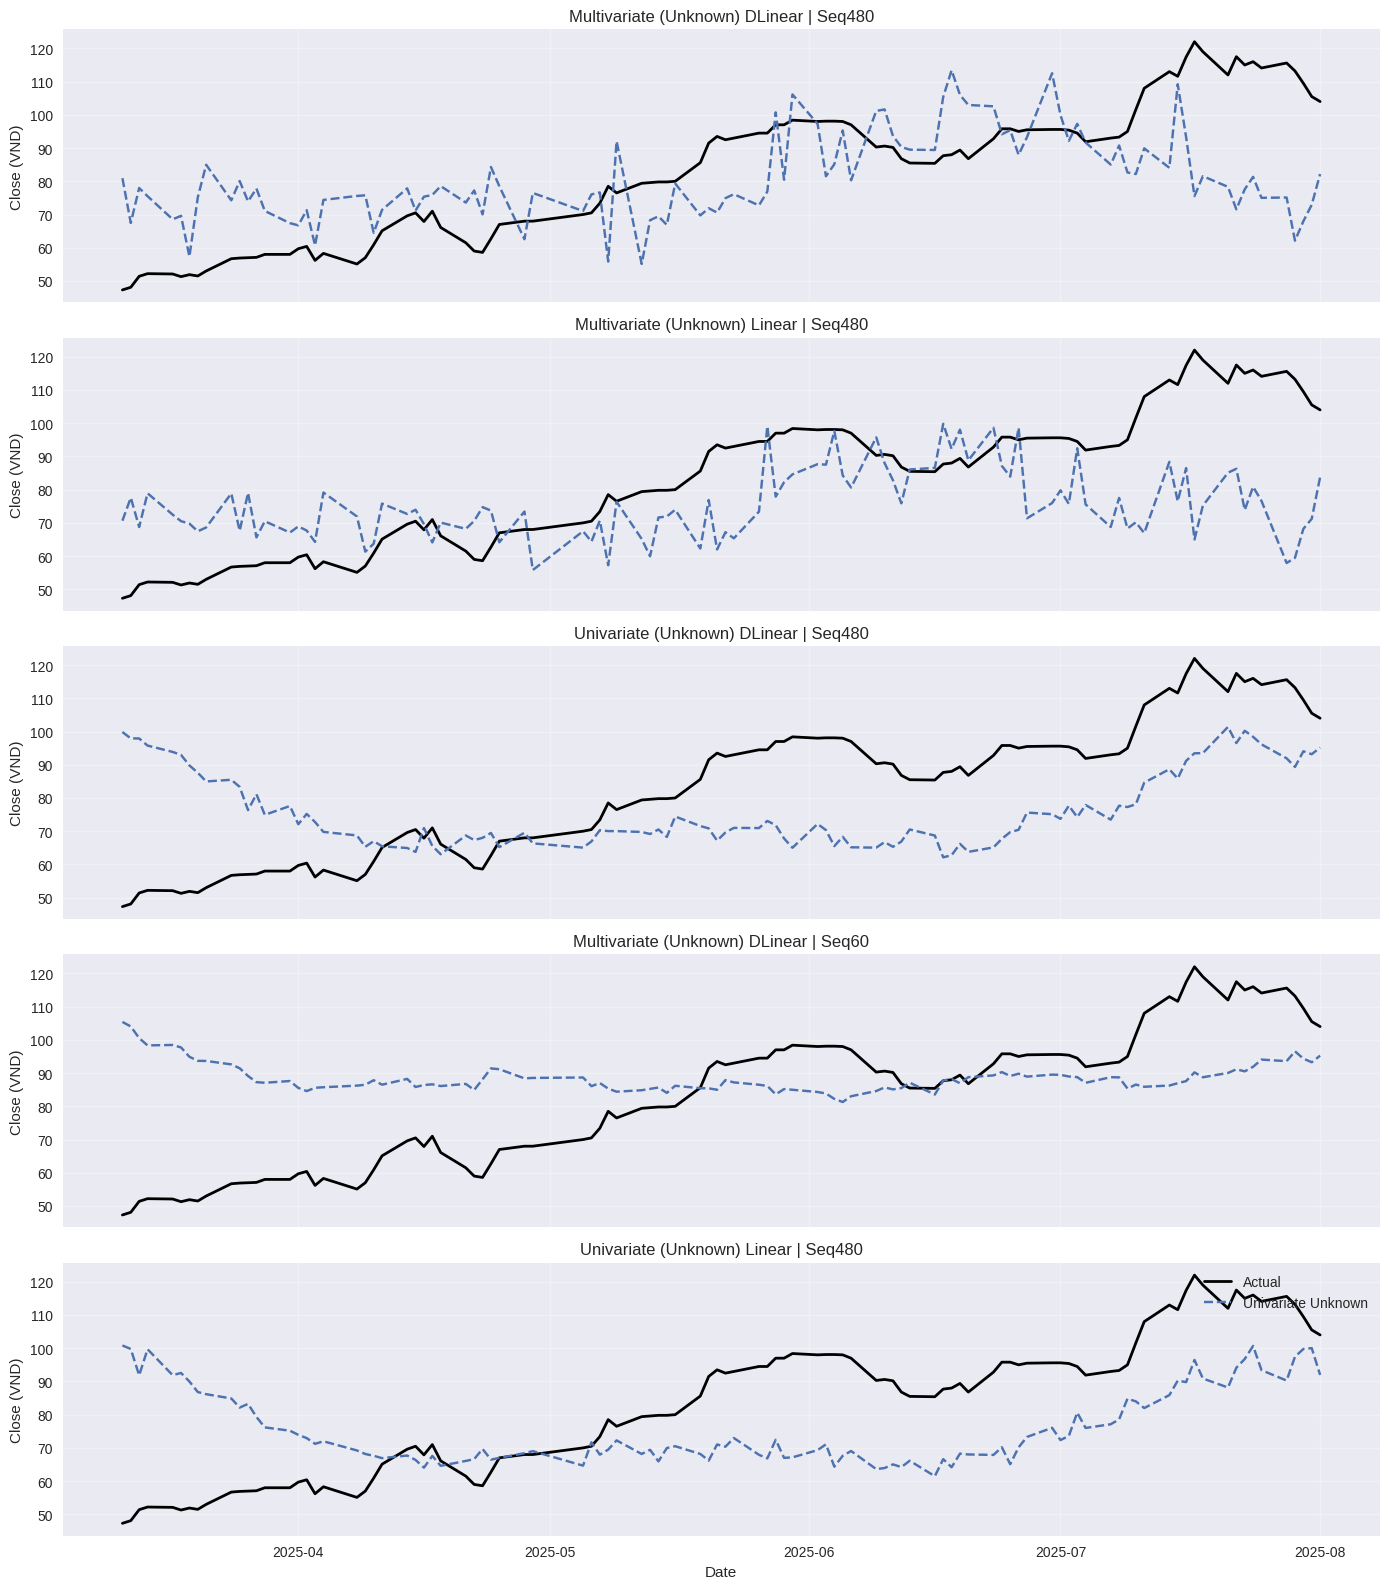

In [38]:
# top_k = min(4, len(comparison_df))
top_k = 5
if top_k == 0:
    print('Không có bản ghi để vẽ.')
else:
    fig, axes = plt.subplots(top_k, 1, figsize=(14, 3.2 * top_k), sharex=True)
    if top_k == 1:
        axes = [axes]
    for ax, (_, row) in zip(axes, comparison_df.head(top_k).iterrows()):
        forecast_df = pd.read_csv(row['ForecastFile'])
        preds = forecast_df['close'].astype(float).values
        aligned_len = min(len(preds), len(hidden_close))
        ax.plot(hidden_df['time'][:aligned_len], hidden_close[:aligned_len], label='Actual', color='black', linewidth=2)
        # Fix for missing Horizon key
        horizon = row.get('Horizon')
        if pd.isna(horizon) or horizon is None:
            import re
            match = re.search(r'Seq(\d+)', str(row['Model']))
            horizon = match.group(1) if match else 'Unknown'
        ax.plot(hidden_df['time'][:aligned_len], preds[:aligned_len], label=f"{row['Model']} {horizon}", linestyle='--')
        ax.set_title(f"{row['Model']} ({horizon}) {row['Config']}")
        ax.set_ylabel('Close (VND)')
        ax.grid(True, alpha=0.3)
    axes[-1].set_xlabel('Date')
    axes[-1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [39]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from IPython.display import display

def evaluate_submissions(hidden_close, submissions_dir='./submissions/', default_val_mse=np.nan):
    """
    Hàm quét thư mục submission và so sánh với hidden_close.
    
    Args:
        hidden_close (array-like): Dữ liệu thực tế để so sánh.
        submissions_dir (str): Đường dẫn đến thư mục chứa file csv.
        default_val_mse (float/nan): Giá trị gán cho valMSE nếu không parse được từ tên file.
    
    Returns:
        pd.DataFrame: Bảng kết quả so sánh.
    """
    
    # 1. Lấy danh sách file
    if not os.path.exists(submissions_dir):
        print(f"⚠️ Thư mục không tồn tại: {submissions_dir}")
        return pd.DataFrame()

    forecast_files = sorted([f for f in os.listdir(submissions_dir) 
                             if f.endswith('.csv') and (f.startswith('Ext_') or f.startswith('Sub_'))])

    if not forecast_files:
        print(f"⚠️ Không tìm thấy file .csv nào trong {submissions_dir}")
        return pd.DataFrame()
    else:
        print(f"Đã tìm thấy {len(forecast_files)} file dự báo. Đang tính toán...")

    records = []
    max_len = len(hidden_close) 

    for filename in forecast_files:
        file_path = os.path.join(submissions_dir, filename)
        try:
            forecast_df = pd.read_csv(file_path)
            
            if 'close' not in forecast_df.columns:
                continue
                
            preds = forecast_df['close'].astype(float).values
            
            # Cắt ngắn hoặc giữ nguyên độ dài
            aligned_len = min(len(preds), max_len)
            if aligned_len == 0: continue
                
            preds_clip = preds[:aligned_len]
            actual_clip = hidden_close[:aligned_len]
            
            # Metrics
            mse = mean_squared_error(actual_clip, preds_clip)
            # mae = mean_absolute_error(actual_clip, preds_clip) # (Optional)
                
            # --- LOGIC PARSE TÊN FILE & CUSTOM VAL_MSE ---
            slug = filename.replace('.csv', '')
            
            # Khởi tạo giá trị mặc định để tránh lỗi NameError
            val_mse = default_val_mse
            
            if filename.startswith('Sub_'):
                parts = slug.split('_')
                # Format: Sub_{Model}_{HMM}_{Win}_{Seq}_{MSE}
                # Cần ít nhất 6 phần: Sub, Model(1+), HMM, Win, Seq, MSE
                if len(parts) >= 4:
                    try:
                        mse_tag = parts[-1]   # MSExxx
                        # Ưu tiên check testMSE/ValMSE trước MSE để tránh lỗi replace sót ký tự (vd: testMSE -> test)
                        if 'testMSE' in mse_tag:
                            val_mse = int(mse_tag.replace('testMSE', ''))
                        elif 'ValMSE' in mse_tag:
                            val_mse = int(mse_tag.replace('ValMSE', ''))
                        elif 'MSE' in mse_tag:
                            val_mse = int(mse_tag.replace('MSE', ''))
                        
                        seq_tag = parts[-2]
                        win_tag = parts[-3]
                        hmm_tag = parts[-4]
                        model_name = "_".join(parts[1:-4])
                        info_str = f"{hmm_tag} | {seq_tag}"
                    except:
                        # Fallback nếu parse lỗi
                        model_name = slug
                        info_str = "Parse Error"
                else:
                    model_name = slug
                    info_str = "Custom Structure"
            else:
                # Legacy files
                clean_name = slug.replace('submission_', '').replace('_100d', '')
                model_name = clean_name
                info_str = "Legacy"

            records.append({
                'Model': model_name,
                'Config': info_str,
                'hiddenMSE': int(mse),
                'trainMSE': val_mse,
                'Filename': filename
            })
            
        except Exception as e:
            print(f"Lỗi file {filename}: {e}")

    # Tạo bảng và hiển thị
    if records:
        comparison_df = pd.DataFrame(records).sort_values('hiddenMSE').reset_index(drop=True)
        
        # Display style
        display(comparison_df.style.background_gradient(subset=['hiddenMSE', 'trainMSE'], cmap='RdYlGn_r'))
        return comparison_df
    else:
        print("Chưa có dữ liệu.")
        return pd.DataFrame()

In [40]:
df_result = evaluate_submissions(hidden_close, submissions_dir='./submissions/VIC/')

Đã tìm thấy 16 file dự báo. Đang tính toán...


,Model,Config,hiddenMSE,trainMSE,Filename
0,Multivariate,DLinear | Seq480,381,98,Sub_Multivariate_DLinear_NoHMM_Seq480_MSE98.csv
1,Multivariate,Linear | Seq480,439,93,Sub_Multivariate_Linear_NoHMM_Seq480_MSE93.csv
2,Univariate,DLinear | Seq480,506,73,Sub_Univariate_DLinear_NoHMM_Seq480_MSE73.csv
3,Multivariate,DLinear | Seq60,510,18,Sub_Multivariate_DLinear_NoHMM_Seq60_MSE18.csv
4,Univariate,Linear | Seq480,513,72,Sub_Univariate_Linear_NoHMM_Seq480_MSE72.csv
5,Multivariate,Linear | Seq60,536,17,Sub_Multivariate_Linear_NoHMM_Seq60_MSE17.csv
6,Univariate,DLinear | Seq60,652,10,Sub_Univariate_DLinear_NoHMM_Seq60_MSE10.csv
7,Univariate,Linear | Seq60,659,10,Sub_Univariate_Linear_NoHMM_Seq60_MSE10.csv
8,Univariate,DLinear | Seq60,673,15,Sub_Univariate_DLinear_HMM3W30_Seq60_MSE15.csv
9,Univariate,Linear | Seq60,680,14,Sub_Univariate_Linear_HMM3W30_Seq60_MSE14.csv
